# Signal Processing Examples

Create a simple sine wave and Plot it

Sine Wave formula: If you forget the formula, don’t worry. 

y(t) = A * sin(2 * pi * f * t)

Where,
y(t) is the y axis sample we want to calculate for x axis sample t.

A is the amplitude. 

pi is 3.14159.

f is the frequency.

t is our sample. Since we need to convert it to digital, we will divide it by the sampling rate.

where I have used the numpy linspace command to create an array which runs from 0 to two pi with 100 samples. If you want to create more plot-windows you can use the command plt.figure. Access the windows with the commands plt.figure(1), plt.figure(2). It is also possible to combine plot windows into one with the command subplot.
How to make it look nice? Here is an example:


Creating a Signal
Sine waves are sometimes called pure tones because they represent a single frequency. You’ll use sine waves to generate the audio since they will form distinct peaks in the resulting frequency spectrum.

Here’s some code that generates a sine wave:

In [2]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

The x-coordinates of the sine wave are evenly spaced between 0 and DURATION, so the code uses NumPy’s linspace() to generate them. It takes a start value, an end value, and the number of samples to generate. Setting endpoint=False is important for the Fourier transform to work properly because it assumes a signal is periodic.

np.sin() calculates the values of the sine function at each of the x-coordinates. The result is multiplied by the frequency to make the sine wave oscillate at that frequency, and the product is multiplied by 2π to convert the input values to radians.

After you define the function, you use it to generate a two-hertz sine wave that lasts five seconds and plot it using Matplotlib. Your sine wave plot should look something like this:

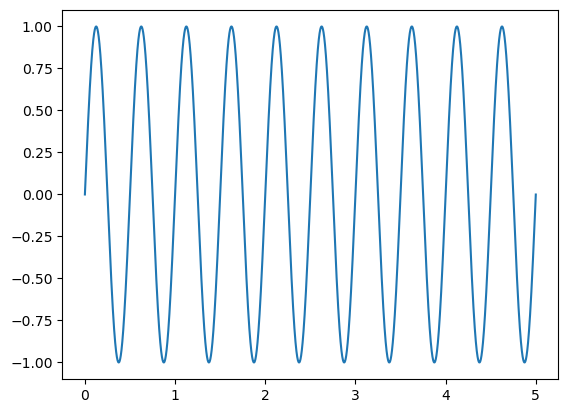

In [3]:
# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

The x-axis represents time in seconds, and since there are two peaks for each second of time, you can see that the sine wave oscillates twice per second. This sine wave is too low a frequency to be audible, so in the next section, you’ll generate some higher-frequency sine waves, and you’ll see how to mix them.

Mixing Audio Signals
The good news is that mixing audio signals consists of just two steps:

1. Adding the signals together
2. Normalizing the result
Before you can mix the signals together, you need to generate them:

In [4]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone

There’s nothing new in this code example. It generates a medium-pitch tone and a high-pitch tone assigned to the variables nice_tone and noise_tone, respectively. You’ll use the high-pitch tone as your unwanted noise, so it gets multiplied by 0.3 to reduce its power. The code then adds these tones together. Note that you use the underscore (_) to discard the x values returned by generate_sine_wave().

The next step is normalization, or scaling the signal to fit into the target format. Due to how you’ll store the audio later, your target format is a 16-bit integer, which has a range from -32768 to 32767:

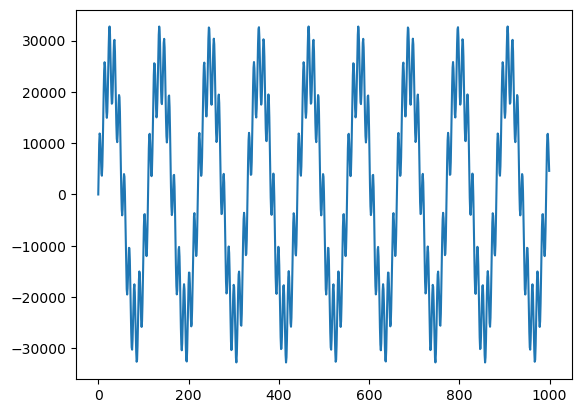

In [5]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

plt.plot(normalized_tone[:1000])
plt.show()

Here, the code scales mixed_tone to make it fit snugly into a 16-bit integer and then cast it to that data type using NumPy’s np.int16. Dividing mixed_tone by its maximum value scales it to between -1 and 1. When this signal is multiplied by 32767, it is scaled between -32767 and 32767, which is roughly the range of np.int16. The code plots only the first 1000 samples so you can see the structure of the signal more clearly.

The signal looks like a distorted sine wave. The sine wave you see is the 400 Hz tone you generated, and the distortion is the 4000 Hz tone. If you look closely, then you can see the distortion has the shape of a sine wave.

To listen to the audio, you need to store it in a format that an audio player can read. The easiest way to do that is to use SciPy’s wavfile.write method to store it in a WAV file. 16-bit integers are a standard data type for WAV files, so you’ll normalize your signal to 16-bit integers:

In [6]:
from scipy.io.wavfile import write

# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("mysinewave.wav", SAMPLE_RATE, normalized_tone)
print(type(normalized_tone))

<class 'numpy.ndarray'>


This code will write to a file mysinewave.wav in the directory where you run your Python script. You can then listen to this file using any audio player or even with Python. You’ll hear a lower tone and a higher-pitch tone. These are the 400 Hz and 4000 Hz sine waves that you mixed.

Once you’ve completed this step, you have your audio sample ready. The next step is removing the high-pitch tone using the Fourier transform!

# Using the Fast Fourier Transform (FFT)


It’s time to use the FFT on your generated audio. The FFT is an algorithm that implements the Fourier transform and can calculate a frequency spectrum for a signal in the time domain, like your audio:

This code will calculate the Fourier transform of your generated audio and plot it. Before breaking it down, take a look at the plot that it produces:

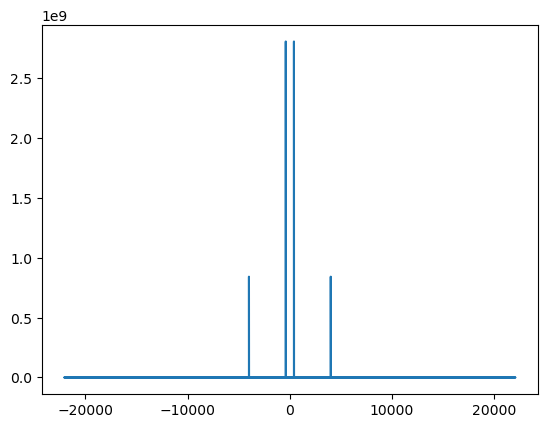

In [7]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = fft(normalized_tone)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

You can see two peaks in the positive frequencies and mirrors of those peaks in the negative frequencies. The positive-frequency peaks are at 400 Hz and 4000 Hz, which corresponds to the frequencies that you put into the audio.

The Fourier transform has taken your complicated, wibbly signal and turned it into just the frequencies it contains. Since you put in only two frequencies, only two frequencies have come out. The negative-positive symmetry is a side effect of putting real-valued input into the Fourier transform, but you’ll hear more about that later.

In the first couple of lines, you import the functions from scipy.fft that you’ll use later and define a variable, N, that stores the total number of samples in the signal.

After this comes the most important section, calculating the Fourier transform:

In [8]:
yf = fft(normalized_tone)
xf = fftfreq(N, 1 / SAMPLE_RATE)

The code calls two very important functions:

- fft() calculates the transform itself.

- fftfreq() calculates the frequencies in the center of each bin in the output of fft(). Without this, there would be no way to plot the x-axis on your frequency spectrum.

A bin is a range of values that have been grouped, like in a histogram. For more information on bins, see this Signal Processing Stack Exchange question. For the purposes of this tutorial, you can think of them as just single values.

Once you have the resulting values from the Fourier transform and their corresponding frequencies, you can plot them:

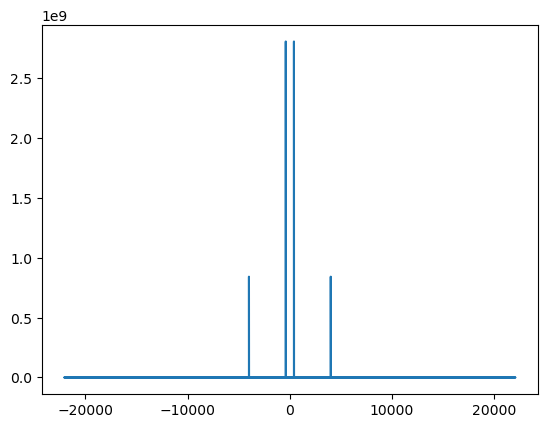

In [9]:
plt.plot(xf, np.abs(yf))
plt.show()

# Making It Faster With rfft()


The frequency spectrum that fft() outputted was reflected about the y-axis so that the negative half was a mirror of the positive half. This symmetry was caused by inputting real numbers (not complex numbers) to the transform.

You can use this symmetry to make your Fourier transform faster by computing only half of it. scipy.fft implements this speed hack in the form of rfft().

The great thing about rfft() is that it’s a drop-in replacement for fft(). Remember the FFT code from before:

In [10]:
yf = fft(normalized_tone)
xf = fftfreq(N, 1 / SAMPLE_RATE)

Swapping in rfft(), the code remains mostly the same, just with a couple of key changes:



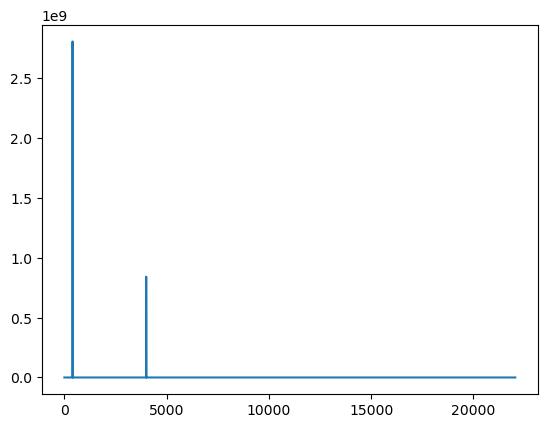

In [11]:
from scipy.fft import rfft, rfftfreq

# Note the extra 'r' at the front
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

Since rfft() returns only half the output that fft() does, it uses a different function to get the frequency mapping, rfftfreq() instead of fftfreq().

rfft() still produces complex output, so the code to plot its result remains the same. The plot, however, should look like the following since the negative frequencies will have disappeared:

You can see that the image above is just the positive side of the frequency spectrum that fft() produces. rfft() never calculates the negative half of the frequency spectrum, which makes it faster than using fft().

Using rfft() can be up to twice as fast as using fft(), but some input lengths are faster than others. If you know you’ll be working only with real numbers, then it’s a speed hack worth knowing.

Now that you have the frequency spectrum of the signal, you can move on to filtering it.

# Filtering the Signal

One great thing about the Fourier transform is that it’s reversible, so any changes you make to the signal in the frequency domain will apply when you transform it back to the time domain. You’ll take advantage of this to filter your audio and get rid of the high-pitched frequency.

The values returned by rfft() represent the power of each frequency bin. If you set the power of a given bin to zero, then the frequencies in that bin will no longer be present in the resulting time-domain signal.

Using the length of xf, the maximum frequency, and the fact that the frequency bins are evenly spaced, you can work out the target frequency’s index:

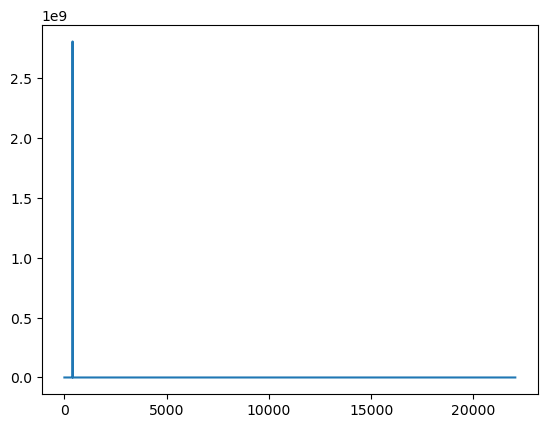

In [12]:
# The maximum frequency is half the sample rate
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Our target frequency is 4000 Hz
target_idx = int(points_per_freq * 4000)

#You can then set yf to 0 at indices around the target frequency to get rid of it:

yf[target_idx - 1 : target_idx + 2] = 0

plt.plot(xf, np.abs(yf))
plt.show()

Since there’s only one peak, it looks like it worked! Next, you’ll apply the inverse Fourier transform to get back to the time domain.

Applying the Inverse FFT
Applying the inverse FFT is similar to applying the FFT:

Since you are using rfft(), you need to use irfft() to apply the inverse. However, if you had used fft(), then the inverse function would have been ifft(). Your plot should now look like this:

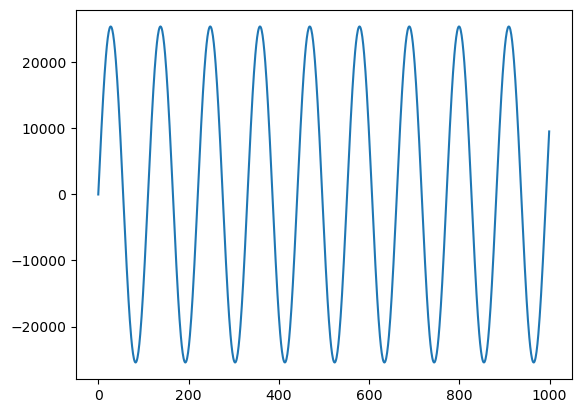

In [13]:
from scipy.fft import irfft

new_sig = irfft(yf)

plt.plot(new_sig[:1000])
plt.show()

As you can see, you now have a single sine wave oscillating at 400 Hz, and you’ve successfully removed the 4000 Hz noise.

Once again, you need to normalize the signal before writing it to a file. You can do it the same way as last time:

In [14]:
norm_new_sig = np.int16(new_sig * (32767 / new_sig.max()))

write("clean.wav", SAMPLE_RATE, norm_new_sig)

# Feature extraction using FFT

/var/folders/fd/bywvldn11db7qy_6g7qh55f80000gn/T/ipykernel_31109/824472952.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('body_acc_x_train.txt', header=None, delim_whitespace=True) # Every row shows a 128 element vector


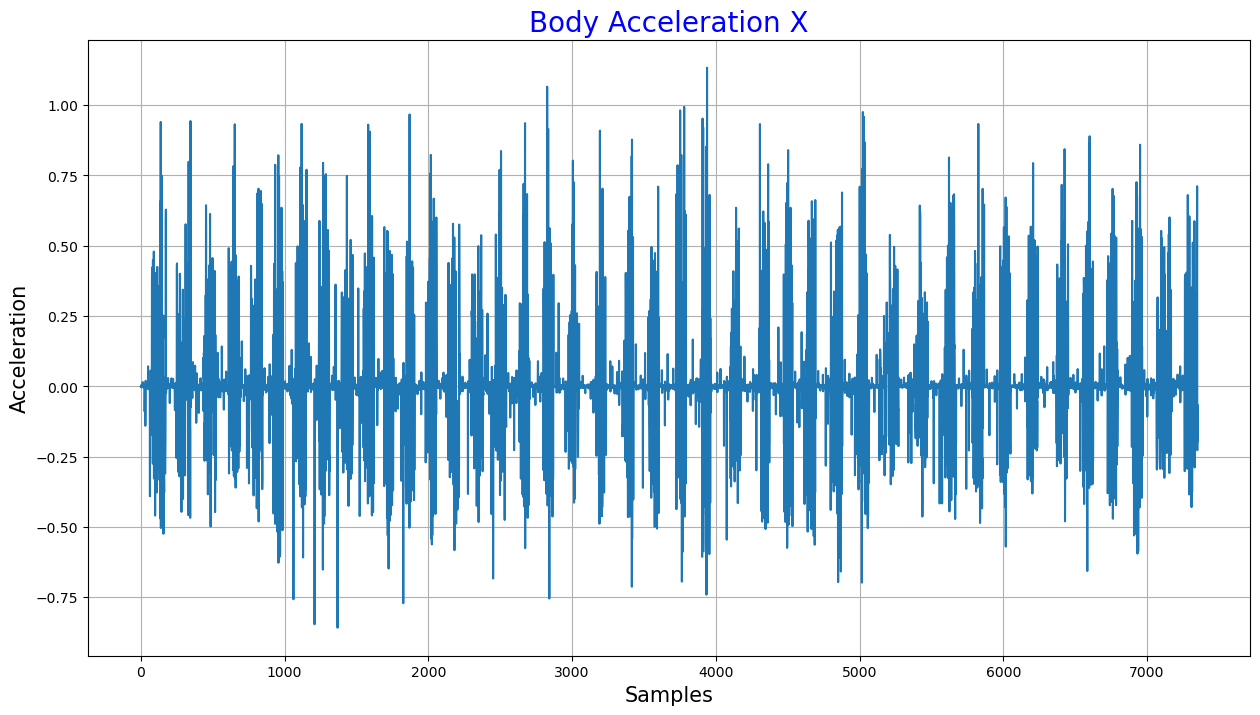

In [15]:
# Import library
import requests, zipfile 
import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fft import fft, fftfreq

# Download data from the source
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
r = requests.get(url, allow_redirects=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path='tmp/') # extract all data in tmp folder

#change dir to the folder with data
os.chdir('tmp/UCI HAR Dataset/train/Inertial Signals')

# The body acceleration signal obtained by subtracting the gravity from the total acceleration.
df = pd.read_csv('body_acc_x_train.txt', header=None, delim_whitespace=True) # Every row shows a 128 element vector

# We want only one acquisition, so
acquisition = df[0]

# Let's look at the data
acquisition.plot(figsize = [15,8])
plt.title("Body Acceleration X",size = 20, color = 'b')
plt.xlabel("Samples", size=15)
plt.ylabel("Acceleration", size=15)
plt.grid()

In [16]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [17]:
FEATURES = ['MIN','MAX','MEAN','RMS','VAR','STD','POWER','PEAK','P2P','CREST FACTOR','SKEW','KURTOSIS',
            'MAX_f','SUM_f','MEAN_f','VAR_f','PEAK_f','SKEW_f','KURTOSIS_f']

def features_extraction(df): 
    
    
    Min=[];Max=[];Mean=[];Rms=[];Var=[];Std=[];Power=[];Peak=[];Skew=[];Kurtosis=[];P2p=[];CrestFactor=[];
    FormFactor=[]; PulseIndicator=[];
    Max_f=[];Sum_f=[];Mean_f=[];Var_f=[];Peak_f=[];Skew_f=[];Kurtosis_f=[]
    
    X = df.values
    ## TIME DOMAIN ##

    Min.append(np.min(X))
    Max.append(np.max(X))
    Mean.append(np.mean(X))
    Rms.append(np.sqrt(np.mean(X**2)))
    Var.append(np.var(X))
    Std.append(np.std(X))
    Power.append(np.mean(X**2))
    Peak.append(np.max(np.abs(X)))
    P2p.append(np.ptp(X))
    CrestFactor.append(np.max(np.abs(X))/np.sqrt(np.mean(X**2)))
    Skew.append(stats.skew(X))
    Kurtosis.append(stats.kurtosis(X))
    FormFactor.append(np.sqrt(np.mean(X**2))/np.mean(X))
    PulseIndicator.append(np.max(np.abs(X))/np.mean(X))
    ## FREQ DOMAIN ##
    ft = fft(X)
    S = np.abs(ft**2)/len(df)
    Max_f.append(np.max(S))
    Sum_f.append(np.sum(S))
    Mean_f.append(np.mean(S))
    Var_f.append(np.var(S))
    
    Peak_f.append(np.max(np.abs(S)))
    Skew_f.append(stats.skew(X))
    Kurtosis_f.append(stats.kurtosis(X))
    #Create dataframe from features
    df_features = pd.DataFrame(index = [FEATURES], 
                               data = [Min,Max,Mean,Rms,Var,Std,Power,Peak,P2p,CrestFactor,Skew,Kurtosis,
                                       Max_f,Sum_f,Mean_f,Var_f,Peak_f,Skew_f,Kurtosis_f])
    return df_features

In [18]:
features_extraction(df)

,0
MIN,-1.232238
MAX,1.299912
MEAN,-0.000636
RMS,0.194847
VAR,0.037965
STD,0.194846
POWER,0.037966
PEAK,1.299912
P2P,2.53215
CREST FACTOR,6.671437


# Wavelet Transform

In [19]:
import pywt

def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

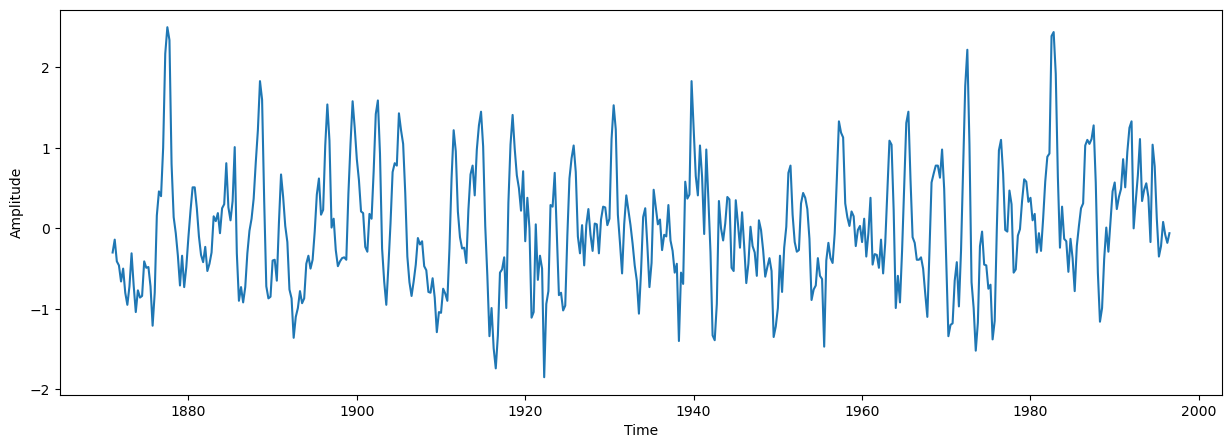

In [20]:
df_nino = pd.read_table('http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat')
N = df_nino.shape[0]
t0 = 1871
dt = 0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

fig, ax = plt.subplots(1, 1, figsize = (15, 5), dpi= 100)
ax.plot(time, signal,)
plt.gca().set(xlabel = 'Time', ylabel = 'Amplitude') 
plt.show()

/opt/anaconda3/envs/DVA256/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


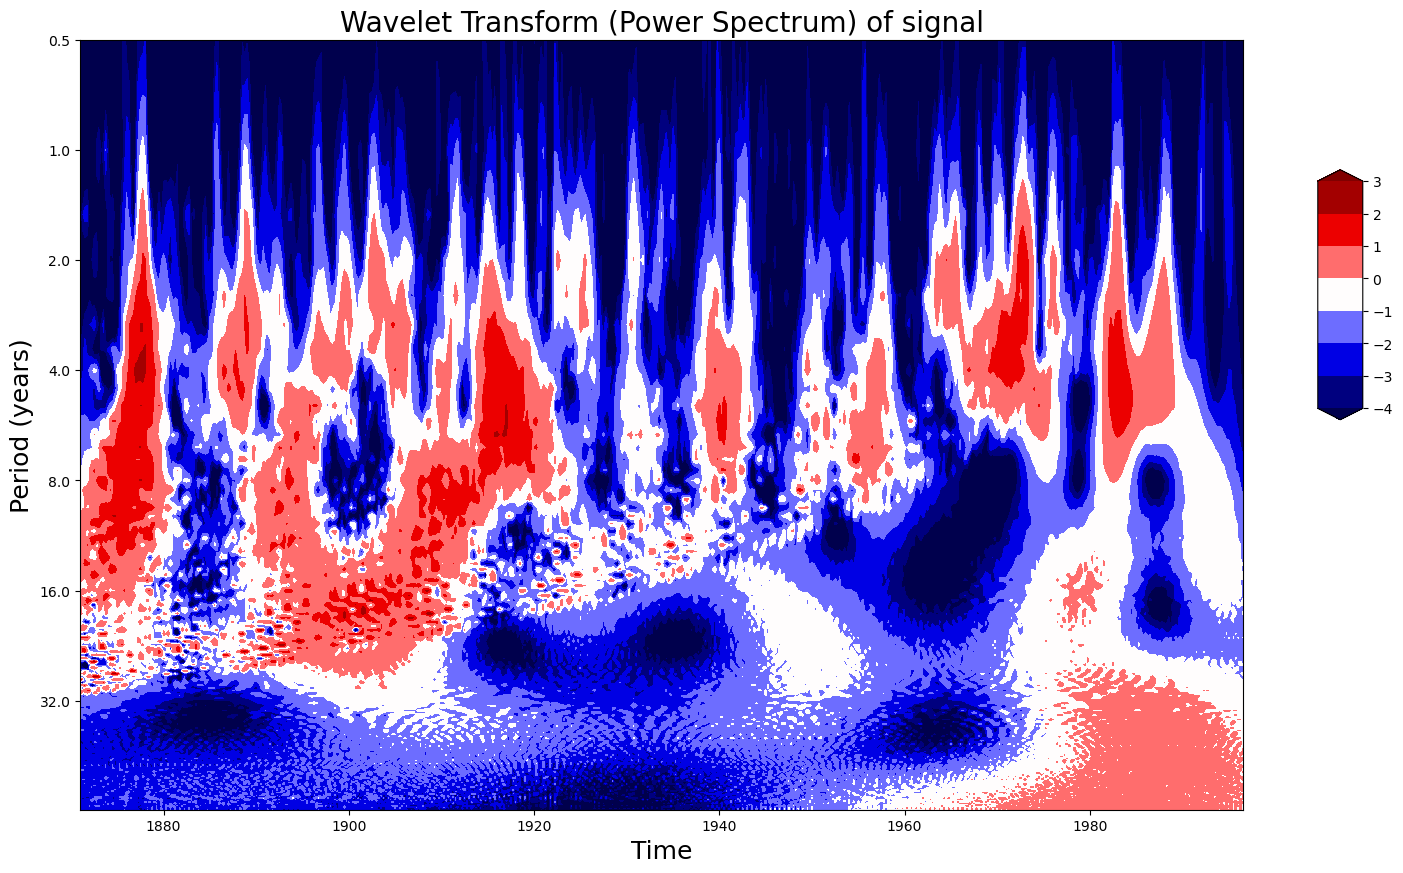

In [21]:
# scale is required to create periods within the time, check the variation by changing 128 with powers of 2, e.g., 256, 64, 32, etc.
scales = np.arange(1, 128)
plot_wavelet(time, signal, scales) # defined above, wavelet transformation is done with pywt.cwt

It can be seen that most of the power is concentrated in a 2-8 year period. If we convert this to frequency (T = 1 / f) this corresponds with a frequency of 0.125 – 0.5 Hz. The increase in power can also be seen if the Fourier transform is plotted around these frequency values.

# Approximate Entropy / Signal Complexity

In [22]:
# generating a regular signal with sine function
duration = 10
sample_rate = 256
x = np.linspace(0, duration, sample_rate * duration, endpoint = False)
frequency = 2
amplitude = 3 
sample_points = frequency * x
signal1 = amplitude * np.sin((2 * np.pi) * sample_points)

# generating a random noisy signal
signal2 = np.random.randn(2500)

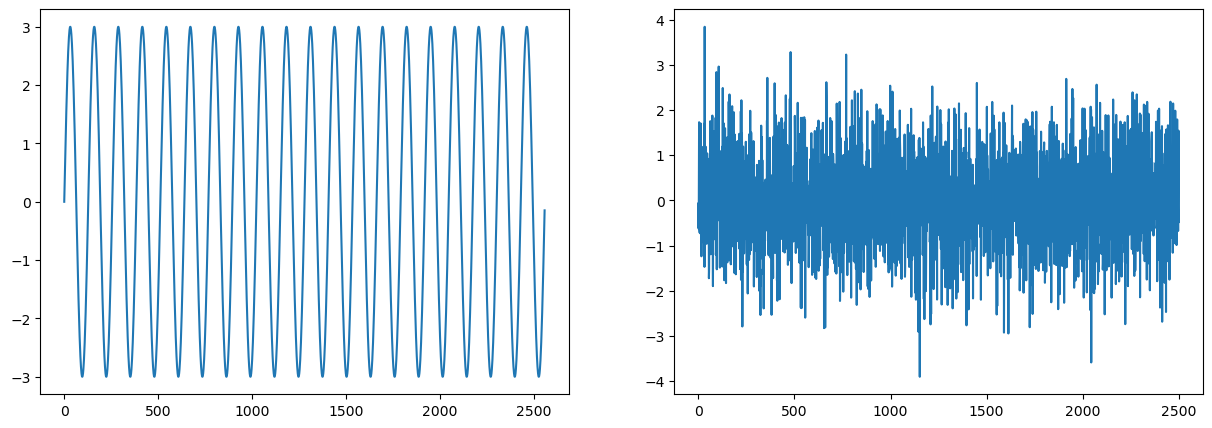

In [23]:
# visualising the signals
fig, axs = plt.subplots(1, 2, figsize = (15, 5), dpi= 100)
axs[0].plot(signal1)
axs[1].plot(signal2)
plt.show()

In [24]:
# computing the signal complexities/entropy for both the signals.
from scipy.stats import entropy
from scipy.fft import fft

entropy1 = entropy(np.abs(fft(signal1)))
entropy2 = entropy(np.abs(fft(signal2)))

print('signal 1 (regular wave):', entropy1)
print('signal 2 (random noise):', entropy2)

signal 1 (regular wave): 0.6931471805620348
signal 2 (random noise): 7.68267714175431


# Principal Component Analysis (PCA) 

PCA for Data Visualization

For a lot of machine learning applications it helps to be able to visualize your data. Visualizing 2 or 3 dimensional data is not that challenging. However, even the Iris dataset used in this part of the tutorial is 4 dimensional. You can use PCA to reduce that 4 dimensional data into 2 or 3 dimensions so that you can plot and hopefully understand the data better.

Load Iris Dataset

The Iris dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. The code below will load the iris dataset.

In [25]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
df

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Standardize the Data
PCA is effected by scale so you need to scale the features in your data before applying PCA. Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. If you want to see the negative effect not scaling your data can have, scikit-learn has a section on the effects of not standardizing your data.

In [26]:
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
x1 = StandardScaler().fit_transform(x)

In [27]:
print ('print x',x)
print ('print x1', x1)

print x [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.1 1.5 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.

PCA Projection to 2D
The original data has 4 columns (sepal length, sepal width, petal length, and petal width). In this section, the code projects the original data which is 4 dimensional into 2 dimensions. I should note that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [29]:
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
print(df['target'])

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: target, Length: 150, dtype: object


Concatenating DataFrame along axis = 1. finalDf is the final DataFrame before plotting the data.


Visualize 2D Projection
This section is just plotting 2 dimensional data. Notice on the graph below that the classes seem well separated from each other.

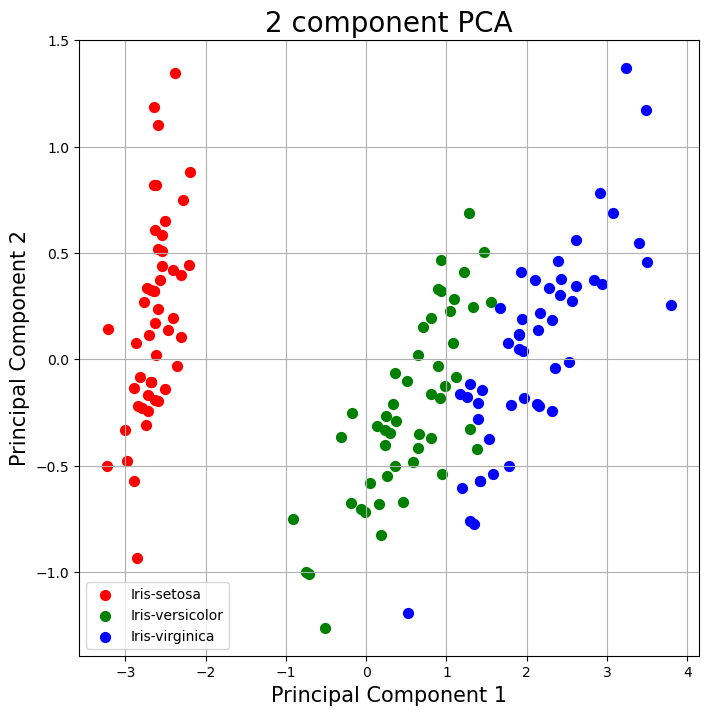

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Explained Variance:
The explained variance tells you how much information (variance) can be attributed to each of the principal components. This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this. By using the attribute explained_variance_ratio_, you can see that the first principal component contains 72.77% of the variance and the second principal component contains 23.03% of the variance. Together, the two components contain 95.80% of the information.

In [31]:
pca.explained_variance_ratio_

array([0.92461621, 0.05301557])

# Removing Noise using PCA

Loading Dataset

In [32]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person = 5, resize = 0.4)

print(faces.images.shape)
n_samples, h, w = faces.images.shape # storing the number of images

(5985, 50, 37)


In [33]:
X, y = faces.data, faces.target
print(X)

[[0.24836601 0.2509804  0.30588236 ... 0.05882353 0.05490196 0.05620915]
 [0.13725491 0.1751634  0.22614379 ... 0.95816994 0.95424837 0.95816994]
 [0.46535948 0.47973856 0.49542484 ... 0.151634   0.10196079 0.06666667]
 ...
 [0.23398693 0.30718955 0.38169935 ... 0.10849673 0.10326798 0.10196079]
 [0.1882353  0.23529412 0.44052288 ... 0.3372549  0.3267974  0.4614379 ]
 [0.4888889  0.38431373 0.18692811 ... 0.15686275 0.04575163 0.08627451]]


In [34]:
# helper function to plot a gallery of portraits
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

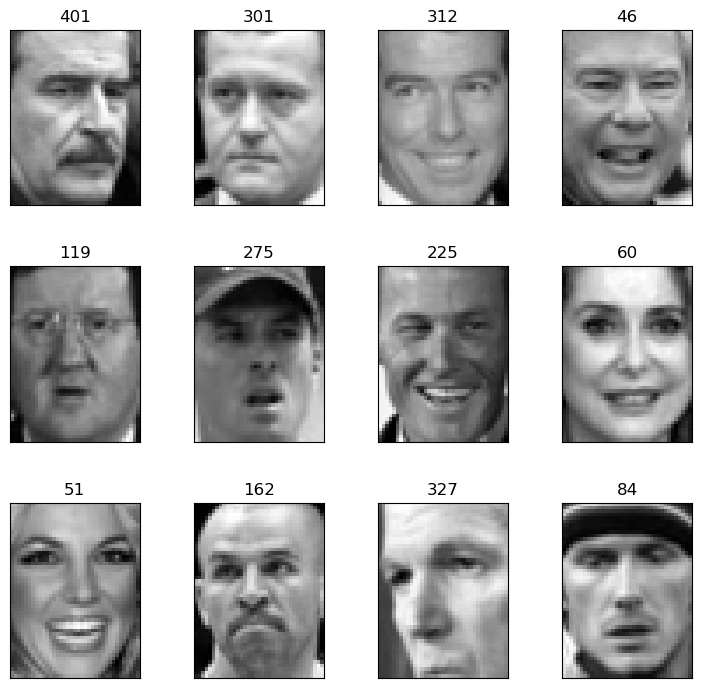

In [35]:
# ploting the face images 
X_faces = X.reshape((X.shape[0], h, w))

X_face_titles = ["%s" % y[i] for i in range(X_faces.shape[0])]
plot_gallery(X_faces, X_face_titles, h, w)

plt.show()

In [36]:
# computing the principle components

n_components = 150
pca = PCA(n_components=n_components)

pca.fit(X)
print(X.shape)
pca_faces = pca.components_.reshape((n_components, h, w))
print(pca_faces.shape)

(5985, 1850)
(150, 50, 37)


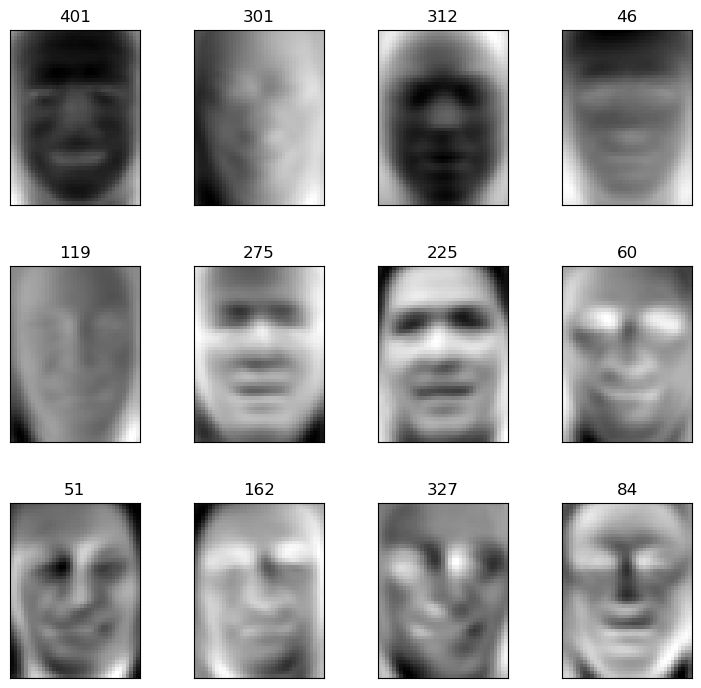

In [37]:
# ploting the face images after computing the principle components
pca_face_titles = ["%s" % y[i] for i in range(pca_faces.shape[0])]
plot_gallery(pca_faces, pca_face_titles, h, w)

plt.show()

In [38]:
# adding random noise to the images
rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X.shape)
X_noisy = X + noise

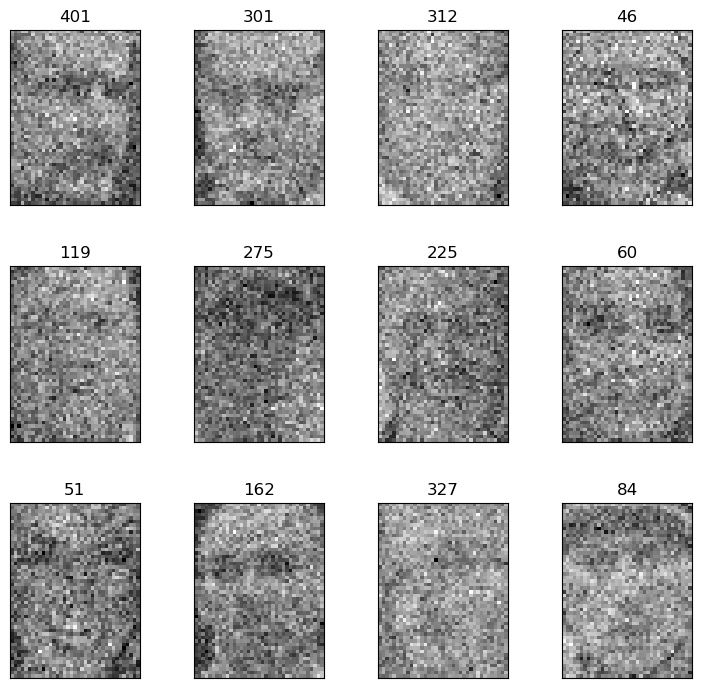

In [39]:
# ploting the noisy face images after computing the principle components

X_noisy_faces = X_noisy.reshape((X_noisy.shape[0], h, w))

X_noisy_faces_titles = ["%s" % y[i] for i in range(X_noisy_faces.shape[0])]
plot_gallery(X_noisy_faces, X_noisy_faces_titles, h, w)

plt.show()

In [40]:
# learning the principle components from the noisy images...
pca.fit(X_noisy)

# reconstructing the images on the basis of the principle components by inverse transformation...
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_noisy))

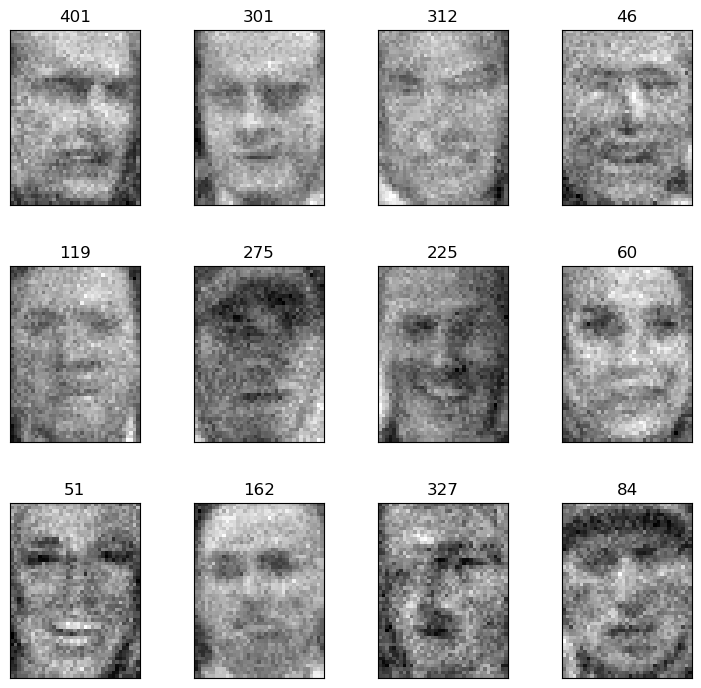

In [41]:
# ploting the clean face images after computing the principle components

X_clean_faces = X_reconstructed_pca.reshape((X_reconstructed_pca.shape[0], h, w))

X_clean_faces_titles = ["%s" % y[i] for i in range(X_clean_faces.shape[0])]
plot_gallery(X_clean_faces, X_clean_faces_titles, h, w)

plt.show()

Though the images are not as clear as the loaded ones, this procedure can be improved through modifying number of components and other parameters while computing the principle components.

Good Luck!